<a href="https://colab.research.google.com/github/imemmul/Food_classification_EfficientNetB4/blob/main/food_classification_EfficientNetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So this colab aims to create a EfficientNetB4 model for 10 class food dataset and compare with B0

The data i get is Daniel Bourke's food data which is divided in to 3 datasets 1 percent, 10 percent and all.

In [69]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-31 21:54:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-31 21:54:08 (99.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [70]:
#importing dependencies
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Getting Data ready

In [71]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-31 21:54:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   168MB/s    in 1.0s    

2022-08-31 21:54:09 (168 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [72]:
unzip_data("10_food_classes_10_percent.zip")

In [73]:
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percen

In [74]:
# 75 images for training 250 images for testing

train_dir_10 = "10_food_classes_10_percent/train/"
test_dir_10 = "10_food_classes_10_percent/test/"

In [75]:
IMG_SIZE = (224, 224)
input_shape = (224, 224, 3)
train_data_10 = tf.keras.utils.image_dataset_from_directory(train_dir_10,
                                                            label_mode="categorical",
                                                            image_size=IMG_SIZE)

test_data = tf. keras.utils.image_dataset_from_directory(test_dir_10,
                                                         label_mode="categorical",
                                                         image_size=IMG_SIZE) # test_data will be always same so i am just attending it once 

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [76]:
train_data_10.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Building models

##### We got data ready now its time to build model i am going to build 4 different models
- model_1 is going to be our base model every tuning will be on this one.
- model_2 is going to be only fitted by augmented data.
- model_3 is going to be augmented data + tuning some layers on model_1 (which is not trainable on model_1)
- model_4 is going to be using all data + model_3 tunings

In [77]:
model = tf.keras.applications.EfficientNetB4(include_top=False)
model.trainable = False # freezing all the layers in model so that we can use them directly

inputs = tf.keras.layers.Input(shape=input_shape) # this is our input layer
x = model(inputs) # inputs passed to the model

# its time pool before outputting

x = tf.keras.layers.GlobalAveragePooling2D()(x) # tf.reduce_mean(inputs, axis=[1, 2])

outputs = tf.keras.layers.Dense(10, activation="softmax")(x) # after pooled get outputs to dense layer

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [79]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_4   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 10)                17930     
                                                                 
Total params: 17,691,753
Trainable params: 17,930
Non-trainable params: 17,673,823
_________________________________________________________________


Before the fit i should create a checkpoint callback in order to call it while fitting

In [80]:
cp_path = "efficient_net_fit_weights/checkpoint"
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,
                                           save_weights_only=True,
                                           save_freq="epoch",
                                           verbose=1)

In [81]:
history_1 = model_1.fit(train_data_10,
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_10),
                        validation_steps=int(0.25*(len(test_data))),
                        epochs=5) # just using 25% of test_data

Epoch 1/5
24/24 [==============================] - 20s 427ms/step - loss: 1.8260 - accuracy: 0.4667 - val_loss: 1.1904 - val_accuracy: 0.7664
Epoch 2/5
24/24 [==============================] - 8s 320ms/step - loss: 1.0490 - accuracy: 0.7480 - val_loss: 0.7950 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 8s 323ms/step - loss: 0.7779 - accuracy: 0.7987 - val_loss: 0.6675 - val_accuracy: 0.8257
Epoch 4/5
24/24 [==============================] - 8s 319ms/step - loss: 0.6476 - accuracy: 0.8307 - val_loss: 0.6148 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 8s 315ms/step - loss: 0.5685 - accuracy: 0.8560 - val_loss: 0.5349 - val_accuracy: 0.8520


Even though we used 10% of data + didn't make any differences tuning or etc. still we got 80 percent on test data.

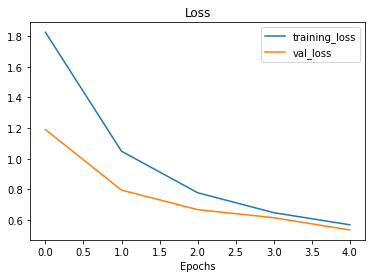

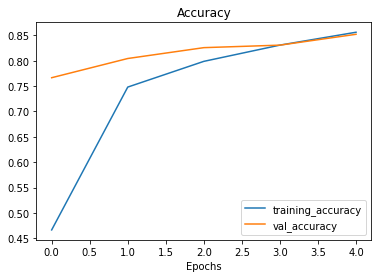

In [82]:
plot_loss_curves(history_1)

Also graphs look cool so its time to play with data

 # Building Data Augmentation Layer

In [83]:
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.Rescaling(scale=1/255.) EfficientNetB4 also uses rescaling inside of it so we dont need to use this
])

In [84]:
import matplotlib.pyplot as plt
import matplotlib.image as imp
import os
import random

In [85]:
from tensorflow.python import training
# lets see how augmented image looks like

def show_augmented_image():
  target_classes = random.choice(train_data_10.class_names)
  target_dir = train_dir_10 + target_classes
  random_image = random.choice(os.listdir(target_dir))
  random_path = target_dir + "/" + random_image
  img = imp.imread(random_path)
  plt.imshow(img)
  plt.axis(False)
  augmented_image = augmentation_layer(img, training=True)
  plt.figure()
  plt.axis(False)
  plt.imshow(augmented_image/255.)

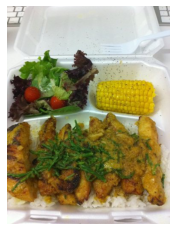

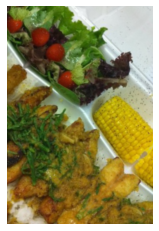

In [86]:
show_augmented_image()

### Building model with augmentated data

In [87]:
model_0 = tf.keras.applications.EfficientNetB4(include_top=False)
model_0.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape)
x = augmentation_layer(inputs)
x = model_0(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data_10,
                        epochs=5,
                        steps_per_epoch=len(train_data_10),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[cp_cb])

Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9891 - accuracy: 0.3627


Epoch 1: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 27s 677ms/step - loss: 1.9891 - accuracy: 0.3627 - val_loss: 1.3519 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3129 - accuracy: 0.6853
Epoch 2: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 12s 503ms/step - loss: 1.3129 - accuracy: 0.6853 - val_loss: 0.9372 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0493 - accuracy: 0.7147
Epoch 3: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 14s 584ms/step - loss: 1.0493 - accuracy: 0.7147 - val_loss: 0.7470 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9542 - accuracy: 0.7280
Epoch 4: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 13s 527ms/step - loss: 0.9542 - acc

### I faced with some problems about vertical flipping so i think from now on i am going to change that flip to horizontal
-- Extra note: after changing flipping to horizontal after fitting val accuracy didn't change.

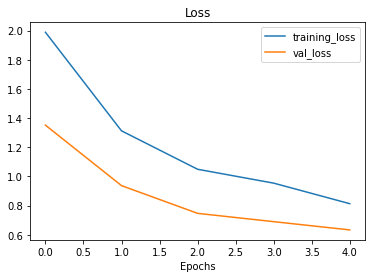

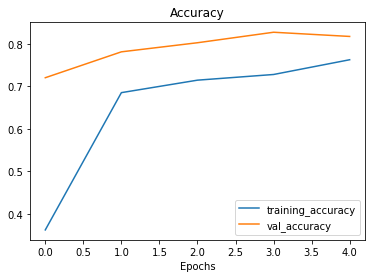

In [88]:
plot_loss_curves(history_2)

### Creating model_3 hardest part begins!!!!
in this model i am going to divide some parts of pretrained imagenet layers in order to train myself.
i hope this is going to work
the other parameters will be same. model_2 will be baseline model after here. In order to use model_2 frequently i am going to use checkpoints to call it.

In [89]:
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_12 True
sequential_2 True
efficientnetb4 False
global_average_pooling2d_5 True
dense_5 True


#### Upthere there are some trainable layers which is not frozen layers that i created also there is a layer of efficientnetb4 which called frozen. lets heat it!!


In [90]:
for layer in model_2.layers[2].layers:
  print(layer.name, layer.trainable)

input_11 False
rescaling_5 False
normalization_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_con

In [91]:
print(len(model_2.layers[2].layers))

474


##### There are "474" layers up there i am going to nearly select last 10% of layers in order to fine tune them lets round this number down and say 45 layers.

In [92]:
print(len(model_0.layers[:-45]))

429


In [93]:
474 - 45

429

#### So we selected last 45 layers up there lets make them trainable in order to fine tuning

In [94]:
for layer in model_0.layers[:-45:-1]:
  layer.trainable = True

In [95]:
for i, layer in enumerate(model_0.layers):
  print(i, " ", layer.name, " ", layer.trainable)

0   input_11   False
1   rescaling_5   False
2   normalization_5   False
3   stem_conv_pad   False
4   stem_conv   False
5   stem_bn   False
6   stem_activation   False
7   block1a_dwconv   False
8   block1a_bn   False
9   block1a_activation   False
10   block1a_se_squeeze   False
11   block1a_se_reshape   False
12   block1a_se_reduce   False
13   block1a_se_expand   False
14   block1a_se_excite   False
15   block1a_project_conv   False
16   block1a_project_bn   False
17   block1b_dwconv   False
18   block1b_bn   False
19   block1b_activation   False
20   block1b_se_squeeze   False
21   block1b_se_reshape   False
22   block1b_se_reduce   False
23   block1b_se_expand   False
24   block1b_se_excite   False
25   block1b_project_conv   False
26   block1b_project_bn   False
27   block1b_drop   False
28   block1b_add   False
29   block2a_expand_conv   False
30   block2a_expand_bn   False
31   block2a_expand_activation   False
32   block2a_dwconv_pad   False
33   block2a_dwconv   False
34   b

In [96]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"]) # here we should drop learning rate in order to prevent huge overfitting i am going to talk about it in other section


In [97]:
for i, layer in enumerate(model_2.layers[2].layers):
   print(i, " ", layer.name, " ", layer.trainable)

0   input_11   False
1   rescaling_5   False
2   normalization_5   False
3   stem_conv_pad   False
4   stem_conv   False
5   stem_bn   False
6   stem_activation   False
7   block1a_dwconv   False
8   block1a_bn   False
9   block1a_activation   False
10   block1a_se_squeeze   False
11   block1a_se_reshape   False
12   block1a_se_reduce   False
13   block1a_se_expand   False
14   block1a_se_excite   False
15   block1a_project_conv   False
16   block1a_project_bn   False
17   block1b_dwconv   False
18   block1b_bn   False
19   block1b_activation   False
20   block1b_se_squeeze   False
21   block1b_se_reshape   False
22   block1b_se_reduce   False
23   block1b_se_expand   False
24   block1b_se_excite   False
25   block1b_project_conv   False
26   block1b_project_bn   False
27   block1b_drop   False
28   block1b_add   False
29   block2a_expand_conv   False
30   block2a_expand_bn   False
31   block2a_expand_activation   False
32   block2a_dwconv_pad   False
33   block2a_dwconv   False
34   b

In [98]:
fine_epochs = 10

history_3 = model_2.fit(train_data_10,
                        epochs=fine_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1])

Epoch 5/10


24/24 [==============================] - ETA: 0s - loss: 1.2864 - accuracy: 0.6600

24/24 [==============================] - 24s 532ms/step - loss: 1.2864 - accuracy: 0.6600 - val_loss: 0.6763 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 13s 544ms/step - loss: 1.2887 - accuracy: 0.6640 - val_loss: 0.6768 - val_accuracy: 0.8076
Epoch 7/10
24/24 [==============================] - 14s 562ms/step - loss: 1.2332 - accuracy: 0.7067 - val_loss: 0.6869 - val_accuracy: 0.8191
Epoch 8/10
24/24 [==============================] - 15s 573ms/step - loss: 1.2227 - accuracy: 0.7013 - val_loss: 0.7577 - val_accuracy: 0.7993
Epoch 9/10
24/24 [==============================] - 13s 557ms/step - loss: 1.2092 - accuracy: 0.6907 - val_loss: 0.7939 - val_accuracy: 0.7845
Epoch 10/10
24/24 [==============================] - 12s 481ms/step - loss: 1.1762 - accuracy: 0.7120 - val_loss: 0.8048 - val_accuracy: 0.7845


In [99]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, None, 3)           0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_5   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 10)                17930     
                                                                 
Total params: 17,691,753
Trainable params: 17,930
Non-trainable params: 17,673,823
__________________________________________

#### So the experiment failed and fine tuning drop the accuracy

In [100]:
model_2.evaluate(test_data)

79/79 [==============================] - 13s 161ms/step - loss: 0.8269 - accuracy: 0.7844


[0.8268830180168152, 0.7843999862670898]

#### Starting again and dropping number of trainable variables

In [124]:
model_2.load_weights(cp_path)

In [125]:
model_2.evaluate(test_data)

79/79 [==============================] - 13s 158ms/step - loss: 0.6511 - accuracy: 0.8200


[0.6510670185089111, 0.8199999928474426]

In [126]:
for layer in model_2.layers[2].layers:
  print(layer.name, " ", layer.trainable)

input_11   False
rescaling_5   False
normalization_5   False
stem_conv_pad   False
stem_conv   False
stem_bn   False
stem_activation   False
block1a_dwconv   False
block1a_bn   False
block1a_activation   False
block1a_se_squeeze   False
block1a_se_reshape   False
block1a_se_reduce   False
block1a_se_expand   False
block1a_se_excite   False
block1a_project_conv   False
block1a_project_bn   False
block1b_dwconv   False
block1b_bn   False
block1b_activation   False
block1b_se_squeeze   False
block1b_se_reshape   False
block1b_se_reduce   False
block1b_se_expand   False
block1b_se_excite   False
block1b_project_conv   False
block1b_project_bn   False
block1b_drop   False
block1b_add   False
block2a_expand_conv   False
block2a_expand_bn   False
block2a_expand_activation   False
block2a_dwconv_pad   False
block2a_dwconv   False
block2a_bn   False
block2a_activation   False
block2a_se_squeeze   False
block2a_se_reshape   False
block2a_se_reduce   False
block2a_se_expand   False
block2a_se_exc

In [127]:
for layer in model_0.layers[:-20]:
  print(layer.name, " ", layer.trainable)
  layer.trainable = False

input_11   False
rescaling_5   False
normalization_5   False
stem_conv_pad   False
stem_conv   False
stem_bn   False
stem_activation   False
block1a_dwconv   False
block1a_bn   False
block1a_activation   False
block1a_se_squeeze   False
block1a_se_reshape   False
block1a_se_reduce   False
block1a_se_expand   False
block1a_se_excite   False
block1a_project_conv   False
block1a_project_bn   False
block1b_dwconv   False
block1b_bn   False
block1b_activation   False
block1b_se_squeeze   False
block1b_se_reshape   False
block1b_se_reduce   False
block1b_se_expand   False
block1b_se_excite   False
block1b_project_conv   False
block1b_project_bn   False
block1b_drop   False
block1b_add   False
block2a_expand_conv   False
block2a_expand_bn   False
block2a_expand_activation   False
block2a_dwconv_pad   False
block2a_dwconv   False
block2a_bn   False
block2a_activation   False
block2a_se_squeeze   False
block2a_se_reshape   False
block2a_se_reduce   False
block2a_se_expand   False
block2a_se_exc

In [128]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [129]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i ," " ,layer.name, " ", layer.trainable)

0   input_11   False
1   rescaling_5   False
2   normalization_5   False
3   stem_conv_pad   False
4   stem_conv   False
5   stem_bn   False
6   stem_activation   False
7   block1a_dwconv   False
8   block1a_bn   False
9   block1a_activation   False
10   block1a_se_squeeze   False
11   block1a_se_reshape   False
12   block1a_se_reduce   False
13   block1a_se_expand   False
14   block1a_se_excite   False
15   block1a_project_conv   False
16   block1a_project_bn   False
17   block1b_dwconv   False
18   block1b_bn   False
19   block1b_activation   False
20   block1b_se_squeeze   False
21   block1b_se_reshape   False
22   block1b_se_reduce   False
23   block1b_se_expand   False
24   block1b_se_excite   False
25   block1b_project_conv   False
26   block1b_project_bn   False
27   block1b_drop   False
28   block1b_add   False
29   block2a_expand_conv   False
30   block2a_expand_bn   False
31   block2a_expand_activation   False
32   block2a_dwconv_pad   False
33   block2a_dwconv   False
34   b

In [107]:
len(model_2.trainable_variables)

2

In [130]:
history_3_second_try = model_2.fit(train_data_10,
                               validation_data=test_data,
                               steps_per_epoch=len(train_data_10),
                               epochs=fine_epochs,
                               validation_steps=int(0.25*len(test_data)),
                               initial_epoch=history_2.epoch[-1])

Epoch 5/10


14/24 [================>.............] - ETA: 3s - loss: 0.8368 - accuracy: 0.7612

KeyboardInterrupt: ignored

#### Decreasing trainable variables worked but still don't do well as we expected. So the other trying might be giving all data but we'll see. Then lets decrease this into 10. 
NEW UPDATE ::::
I DID VERY BIG MISTAKE WHICH WAS NOT DECREASING LEARNING RATE THATS BECAUSE MY MODEL'S ACCURACY WAS LOW SO I AM FITTING DATA AGAIN AND KEEPING EXPERIMENT AFTER THIS I AM GOING TO DECREASE THE NUMBER OF TRAINABLE LAYERS TO 10.

In [116]:
model_2.load_weights(cp_path)

In [131]:
for layer in model_0.layers:
  print(layer.name, " ", layer.trainable)
  layer.trainable = False

input_11   False
rescaling_5   False
normalization_5   False
stem_conv_pad   False
stem_conv   False
stem_bn   False
stem_activation   False
block1a_dwconv   False
block1a_bn   False
block1a_activation   False
block1a_se_squeeze   False
block1a_se_reshape   False
block1a_se_reduce   False
block1a_se_expand   False
block1a_se_excite   False
block1a_project_conv   False
block1a_project_bn   False
block1b_dwconv   False
block1b_bn   False
block1b_activation   False
block1b_se_squeeze   False
block1b_se_reshape   False
block1b_se_reduce   False
block1b_se_expand   False
block1b_se_excite   False
block1b_project_conv   False
block1b_project_bn   False
block1b_drop   False
block1b_add   False
block2a_expand_conv   False
block2a_expand_bn   False
block2a_expand_activation   False
block2a_dwconv_pad   False
block2a_dwconv   False
block2a_bn   False
block2a_activation   False
block2a_se_squeeze   False
block2a_se_reshape   False
block2a_se_reduce   False
block2a_se_expand   False
block2a_se_exc

In [133]:
for layer in model_0.layers[:-10:-1]:
  print(layer.name, " ", layer.trainable)
  layer.trainable = True

top_activation   True
top_bn   True
top_conv   True
block7b_add   True
block7b_drop   True
block7b_project_bn   True
block7b_project_conv   True
block7b_se_excite   True
block7b_se_expand   True


In [134]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [135]:
for layer in model_2.layers[2].layers:
  print(layer.name, " ", layer.trainable)

input_11   False
rescaling_5   False
normalization_5   False
stem_conv_pad   False
stem_conv   False
stem_bn   False
stem_activation   False
block1a_dwconv   False
block1a_bn   False
block1a_activation   False
block1a_se_squeeze   False
block1a_se_reshape   False
block1a_se_reduce   False
block1a_se_expand   False
block1a_se_excite   False
block1a_project_conv   False
block1a_project_bn   False
block1b_dwconv   False
block1b_bn   False
block1b_activation   False
block1b_se_squeeze   False
block1b_se_reshape   False
block1b_se_reduce   False
block1b_se_expand   False
block1b_se_excite   False
block1b_project_conv   False
block1b_project_bn   False
block1b_drop   False
block1b_add   False
block2a_expand_conv   False
block2a_expand_bn   False
block2a_expand_activation   False
block2a_dwconv_pad   False
block2a_dwconv   False
block2a_bn   False
block2a_activation   False
block2a_se_squeeze   False
block2a_se_reshape   False
block2a_se_reduce   False
block2a_se_expand   False
block2a_se_exc

In [ ]:
history_3_third_try = model_2.fit(train_data_10,
                               validation_data=test_data,
                               steps_per_epoch=len(train_data_10),
                               epochs=fine_epochs,
                               validation_steps=int(0.25*len(test_data)),
                               initial_epoch=history_2.epoch[-1])

In [123]:
model = tf.keras.applications.EfficientNetB4(include_top=False)
model.trainable = False # freezing all the layers in model so that we can use them directly

inputs = tf.keras.layers.Input(shape=input_shape) # this is our input layer
x = model(inputs) # inputs passed to the model

# its time pool before outputting

x = tf.keras.layers.GlobalAveragePooling2D()(x) # tf.reduce_mean(inputs, axis=[1, 2])

outputs = tf.keras.layers.Dense(10, activation="softmax")(x) # after pooled get outputs to dense layer

model_without_fine = tf.keras.Model(inputs, outputs)

model_without_fine.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [137]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

unzip_data("10_food_classes_all_data.zip")

--2022-08-31 22:14:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  53.2MB/s    in 9.2s    

2022-08-31 22:14:43 (53.7 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [138]:
train_dir_all = "10_food_classes_all_data/train/"

In [139]:
train_all = tf.keras.utils.image_dataset_from_directory(train_dir_all,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.


In [140]:
history_exp_2 = model_2.fit(train_all,
                            validation_data=test_data,
                            validation_steps=len(test_data),
                            steps_per_epoch=len(train_all),
                            epochs=fine_epochs,
                            initial_epoch=history_2.epoch[-1])

Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.9468 - accuracy: 0.7076

235/235 [==============================] - 91s 386ms/step - loss: 0.9468 - accuracy: 0.7076 - val_loss: 0.6097 - val_accuracy: 0.8224
Epoch 6/10
235/235 [==============================] - 83s 351ms/step - loss: 0.8984 - accuracy: 0.7217 - val_loss: 0.5690 - val_accuracy: 0.8308
Epoch 7/10
235/235 [==============================] - 81s 344ms/step - loss: 0.8786 - accuracy: 0.7328 - val_loss: 0.5462 - val_accuracy: 0.8352
Epoch 8/10
235/235 [==============================] - 76s 320ms/step - loss: 0.8481 - accuracy: 0.7367 - val_loss: 0.5260 - val_accuracy: 0.8416
Epoch 9/10
235/235 [==============================] - 74s 314ms/step - loss: 0.8366 - accuracy: 0.7380 - val_loss: 0.5120 - val_accuracy: 0.8468
Epoch 10/10
235/235 [==============================] - 71s 299ms/step - loss: 0.8210 - accuracy: 0.7477 - val_loss: 0.4992 - val_accuracy: 0.8480


In [141]:
history_not_fine = model_without_fine.fit(train_all,
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          steps_per_epoch=len(train_all),
                                          epochs=5)

Epoch 1/5
235/235 [==============================] - 66s 235ms/step - loss: 0.8346 - accuracy: 0.7580 - val_loss: 0.4254 - val_accuracy: 0.8760
Epoch 2/5
235/235 [==============================] - 52s 221ms/step - loss: 0.5108 - accuracy: 0.8365 - val_loss: 0.3638 - val_accuracy: 0.8856
Epoch 3/5
235/235 [==============================] - 52s 219ms/step - loss: 0.4461 - accuracy: 0.8583 - val_loss: 0.3362 - val_accuracy: 0.8980
Epoch 4/5
235/235 [==============================] - 52s 220ms/step - loss: 0.4061 - accuracy: 0.8712 - val_loss: 0.3222 - val_accuracy: 0.9008
Epoch 5/5
235/235 [==============================] - 52s 220ms/step - loss: 0.3769 - accuracy: 0.8813 - val_loss: 0.3137 - val_accuracy: 0.9064
